# Progetto Applicazioni Data Intensive 2023
## Riconoscimento di un'anomalia

#### Autori: Alessandro Sciarrillo e Niccolò Mussoni

In [1]:
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

NOTE

- dati che si discostano troppo da q3 + 3*iqr dove iqr = q3-q1
- anomalie prolungate considerate come failure -> valutare contare consecutive in api
- mostrare valori dei sensori durante le anomalie

## Contesto e Obbiettivo del modello
(Linee guida: Descrivere in modo chiaro il contesto e l’obiettivo del modello di predizione, la fonte e la struttura del
dataset utilizzato e le variabili che contiene. Eseguire eventualmente una prima scrematura dei dati,
eliminando ad es. variabili palesemente non informative (es. identificatori) o con molti dati nulli.)

### Obiettivo
// TODO

### Dataset
Il dataset (1) raccoglie le misurazioni effettuate dall'APU di un treno nella metro di Porto. Ci concentriamo su una serie di sensori analogici e digitali installati sul treno.
Le misurazioni dei sensori sono state raccolte da Febbraio a Settembre 2020, con un intervallo temporale di 10 secondi tra loro, dove i 15 segnali sono raccolti da un dispositivo embedded a bordo che è capace di trasferire i dati al server usando il protocollo TCP/IP.

(1): https://archive.ics.uci.edu/dataset/791/metropt+3+dataset

In [2]:
file_zip_url = "https://archive.ics.uci.edu/static/public/791/metropt+3+dataset.zip"
file_zip_name = "metropt+3+dataset.zip"
file_data_set_name = "MetroPT3(AirCompressor).csv"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

# specifichiamo tipi di dato per ottimizzare lo spazio occupato
types = {
    "COMP":             np.uint8,
    "DV_eletric":       np.uint8,
    "Towers":           np.uint8,
    "MPG":              np.uint8,
    "LPS":              np.uint8,
    "Pressure_switch":  np.uint8,
    "Oil_level":        np.uint8,
    "Caudal_impulses":  np.uint8
}

df_full = pd.read_csv(file_data_set_name, sep=",", dtype=types, parse_dates=["timestamp"])

df_full.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1,0,1,1,0,1,1,1
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1,0,1,1,0,1,1,1
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1,0,1,1,0,1,1,1
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1,0,1,1,0,1,1,1
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1,0,1,1,0,1,1,1


### Prima fase di pulizia dei dati
Rimuoviamo la prima colonna, in quanto contiene degli identificatori non informativi per il nostro scopo e impostiamo il timestamp come indice.

In [3]:
df = df_full.drop(df_full.columns[[0]], axis=1)
df.set_index(["timestamp"],  inplace=True)
df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1,0,1,1,0,1,1,1
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1,0,1,1,0,1,1,1


### Variabili
#### Valori analogici
- **`TP2`**: pressione del compressore [bar]
- **`TP3`**: pressione generata nel pannello pneumatico [bar]
- **`H1`**: pressione generata a causa di un calo di pressione quando avviene una scarica del filtro separatore ciclonico [bar]
- **`DV_pressure`**: misura del calo di pressione generato quando le torri scaricano gli essiccatori d'aria [bar]
- **`Reservoirs`**: pressione sul fondo dei serbatoi [bar]
- **`Motor_Current`**: corrente di una fase del motore trifase [A]
    - 0A - spento
    - 4A - assenza di carico
    - 7A - sotto carico
    - 9A - in funzione
- **`Oil_Temperature`**: temperatura dell'olio nel compressore [°C]

#### Valori digitali
- **`COMP`**: segnale della valvola di aspirazione dell'aria nel compressore
    - acceso quando non viene aspirata aria, indicando che il compressore è spento o sta lavorando in assenza di carico
- **`DV_eletric`**: segnale che controlla la valvola di scarico del compressore
    - spento se il compressore è spento o sta lavorando in assenza di carico
- **`TOWERS`**: segnale che indica quale torre responsabile dell'umidità dell'aria sta lavorando
    - se spento sta lavorando la prima torre, quella responsabile dell'essicatura dell'aria
    - se acceso sta lavorando la seconda torre, quella responsabile del rilascio dell'umidità rimossa dall'aria
- **`MPG`**: segnale che accende il compressore sotto carico attivando la valvola di aspirazione quando la pressione nell'APU scende sotto 8.2 bar. Attiva il sensore COMP, che ha lo stesso comportamento
- **`LPS`**: segnale che si accende quando la pressione scende sotto 7 bar
- **`Pressure Switch`**: segnale che rileva la fase di scarico nelle torri di essicazione
- **`Oil_Level`**: segnale che rileva il livello dell'olio nel compressore
    - acceso quando il livello dell'olio è sotto i valori attesi
- **`Caudal_Impulse`**: segnale che conta gli impulsi generati dall'aria che va dall'APU ai serbatoi.

### Integrazione con periodi di anomalia verificati
Dal paper (2) che ha raccolto questi dati abbiamo ricavato gli intervalli di data-ora in cui un esperto ha determinato se ci fossero state anomalie nell'APU, comprese nel periodo da Aprile a Luglio 2020.

Definiamo quindi una nuova varibile binaria "Anomaly" con avrà valore 1 per le istanze appartenti ad un lasso di tempo contrassegnato come anomalo, altrimenti 0.

(2): https://ieeexplore.ieee.org/document/9564181

In [4]:
df["Anomaly"] = 0

def set_anomaly(anomaly_intervals):
    anomaly = df["Anomaly"].copy()
    for s, e in anomaly_intervals:
        start = [int(st) for st in s.split(',')]
        end   = [int(en) for en in e.split(',')]
        anomaly_interval = (df.index >= datetime.datetime(*start)) & (df.index <= datetime.datetime(*end))
        anomaly[anomaly_interval] = 1
    df["Anomaly"] = anomaly

anomaly_intervals = [
    ('2020,4,12,11,50,0',   '2020,4,12,23,30,0'),
    ('2020,4,18, 0, 0,0',   '2020,4,18,23,59,0'),
    ('2020,4,19, 0, 0,0',   '2020,4,19, 1,30,0'),
    ('2020,4,29, 3,20,0',   '2020,4,29, 4, 0,0'),
    ('2020,4,29,22, 0,0',   '2020,4,29,22,20,0'),
    ('2020,5,13,14, 0,0',   '2020,5,13,23,59,0'),
    ('2020,5,18, 5, 0,0',   '2020,5,18, 5,30,0'),
    ('2020,5,19,10,10,0',   '2020,5,19,11, 0,0'),
    ('2020,5,19,22,10,0',   '2020,5,19,23,59,0'),
    ('2020,5,20, 0, 0,0',   '2020,5,20,20, 0,0'),
    ('2020,5,23, 9,50,0',   '2020,5,23,10,10,0'),
    ('2020,5,29,23,30,0',   '2020,5,29,23,59,0'),
    ('2020,5,30, 0, 0,0',   '2020,5,30, 6, 0,0'),
    ('2020,6, 1,15, 0,0',   '2020,6, 1,15,40,0'),
    ('2020,6, 3,10, 0,0',   '2020,6, 3,11, 0,0'),
    ('2020,6, 5,10, 0,0',   '2020,6, 5,23,59,0'),
    ('2020,6, 6, 0, 0,0',   '2020,6, 6,23,59,0'),
    ('2020,6, 7, 0, 0,0',   '2020,6, 7,14,30,0'),
    ('2020,7, 8,17,30,0',   '2020,7, 8,19, 0,0'),
    ('2020,7,15,14,30,0',   '2020,7,15,19, 0,0'),
    ('2020,7,17, 4,30,0',   '2020,7,17, 5,30,0')
]

set_anomaly(anomaly_intervals)

mask = (df.index > datetime.datetime(2020, 5, 18, 4, 59, 0)) & (df.index <= datetime.datetime(2020, 5, 18, 5, 1, 0))
df[mask].loc[:, "Anomaly":]

,Anomaly
timestamp,
2020-05-18 04:59:06,0
2020-05-18 04:59:16,0
2020-05-18 04:59:26,0
2020-05-18 04:59:36,0
2020-05-18 04:59:46,0
2020-05-18 04:59:56,0
2020-05-18 05:00:06,1
2020-05-18 05:00:16,1
2020-05-18 05:00:26,1


Dato che il labeling sulle anomalia è stato svolto in un periodo più ristretto rispetto a quello dataset intero, consideriamo i dati relativi solo a quel periodo (Aprile-Luglio 2020)

In [5]:
df = df[ (df.index.date >= datetime.date(2020, 4, 1)) & (df.index.date < datetime.date(2020, 8, 1)) ]
print("Data di inizio del periodo di interesse:", df.index.min(), "\nData di fine del periodo di interesse:\t", df.index.max())

Data di inizio del periodo di interesse: 2020-04-01 00:00:09 
Data di fine del periodo di interesse:	 2020-07-31 23:59:52


## Analisi Esplorativa
(Linee guida: Eseguire un’analisi esplorativa del dataset, riportando statistiche generali (medie, quartili, valori distinti,
indici di correlazione, …) e distribuzioni delle variabili in tabelle e grafici (a torta, istogrammi, a dispersione,
…). Commentare adeguatamente i risultati dell’analisi ed utilizzarli eventualmente per eliminare dati non
utilizzabili nell’analisi.)

In [6]:
df.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,Anomaly
count,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000
mean,1.601,8.959,7.303,0.099,8.960,63.717,2.221,0.804,0.191,0.905,0.797,0.005,0.986,0.974,0.981,0.057
std,3.434,0.664,3.559,0.484,0.663,6.456,2.343,0.397,0.393,0.294,0.403,0.070,0.116,0.161,0.138,0.232
min,-0.032,0.892,-0.036,-0.030,0.870,19.825,0.020,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.014,8.460,8.198,-0.022,8.460,59.350,0.042,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
50%,-0.012,8.926,8.734,-0.020,8.928,64.250,0.045,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
75%,-0.010,9.484,9.360,-0.018,9.484,68.075,3.845,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
max,10.676,10.288,10.288,9.844,10.290,89.050,9.270,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Solo circa il 5.7% delle istanze sono contrassegnate come anomalie. Il Dataset è quindi fortemente sbilanciato.

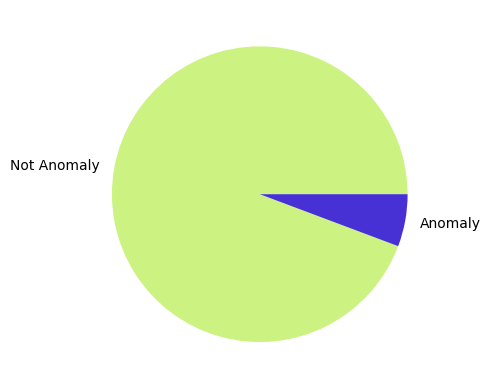

In [7]:
plt.pie( np.bincount(df["Anomaly"]), labels=["Not Anomaly", "Anomaly"], colors=["#CCF381","#4831D4"]);

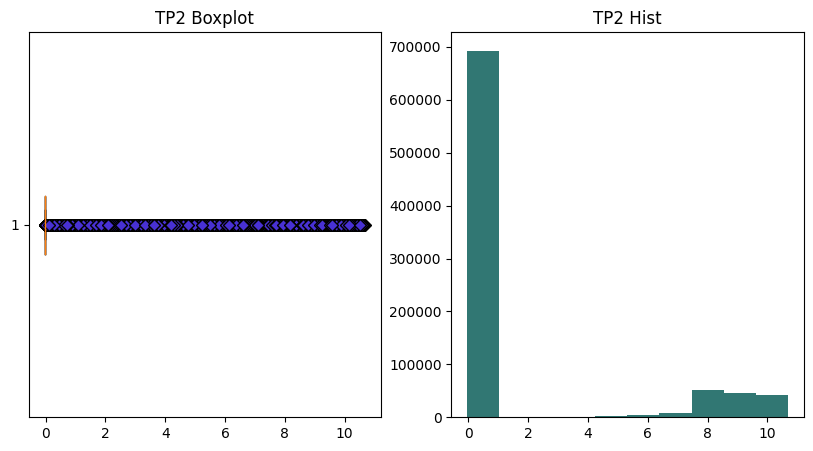

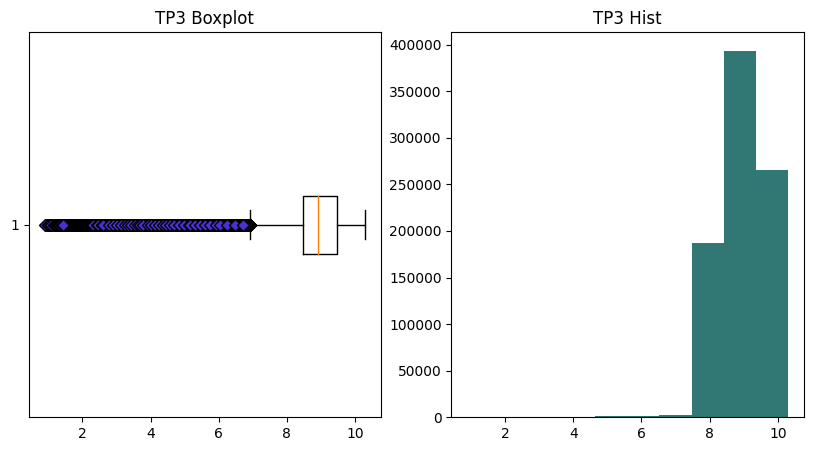

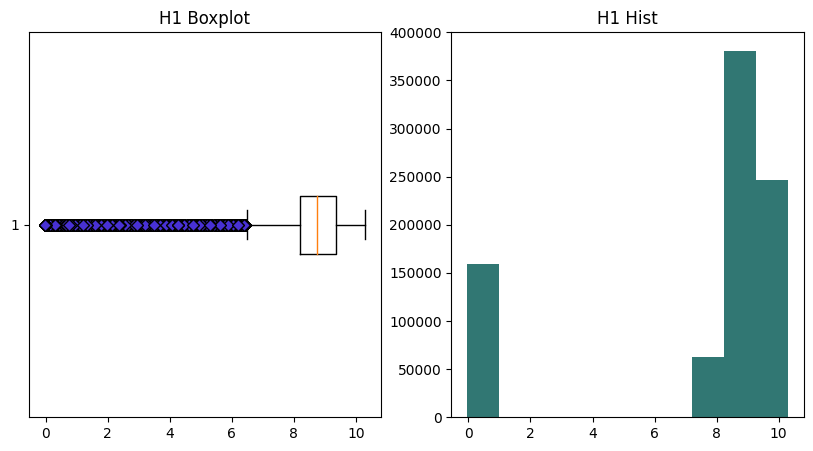

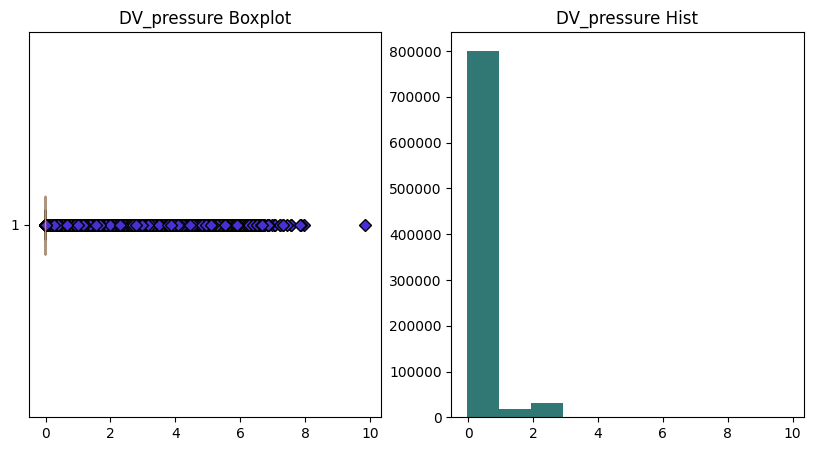

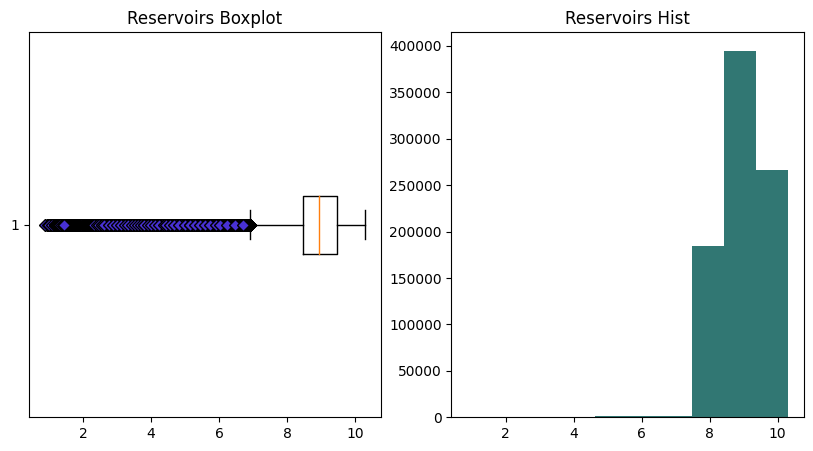

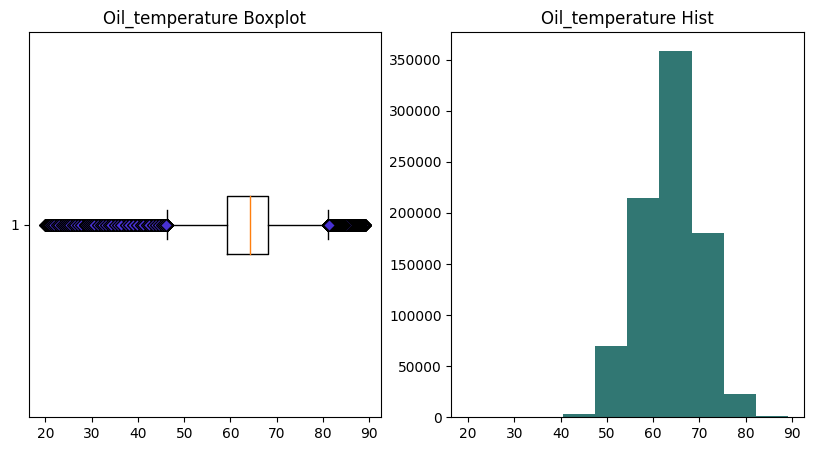

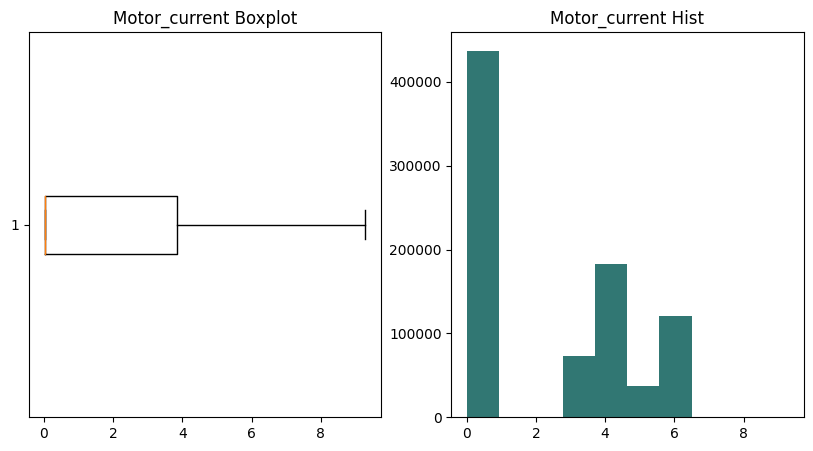

In [8]:
green_diamond = dict(markerfacecolor='#4831D4', marker='D')
for col in df.columns[:7]:
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].set_title(col+" Boxplot")
    ax[1].set_title(col+" Hist")
    ax[0].boxplot(df[col], flierprops=green_diamond, vert=False )
    ax[1].hist(df[col], color=["#317773"])

### Correlazione varibili

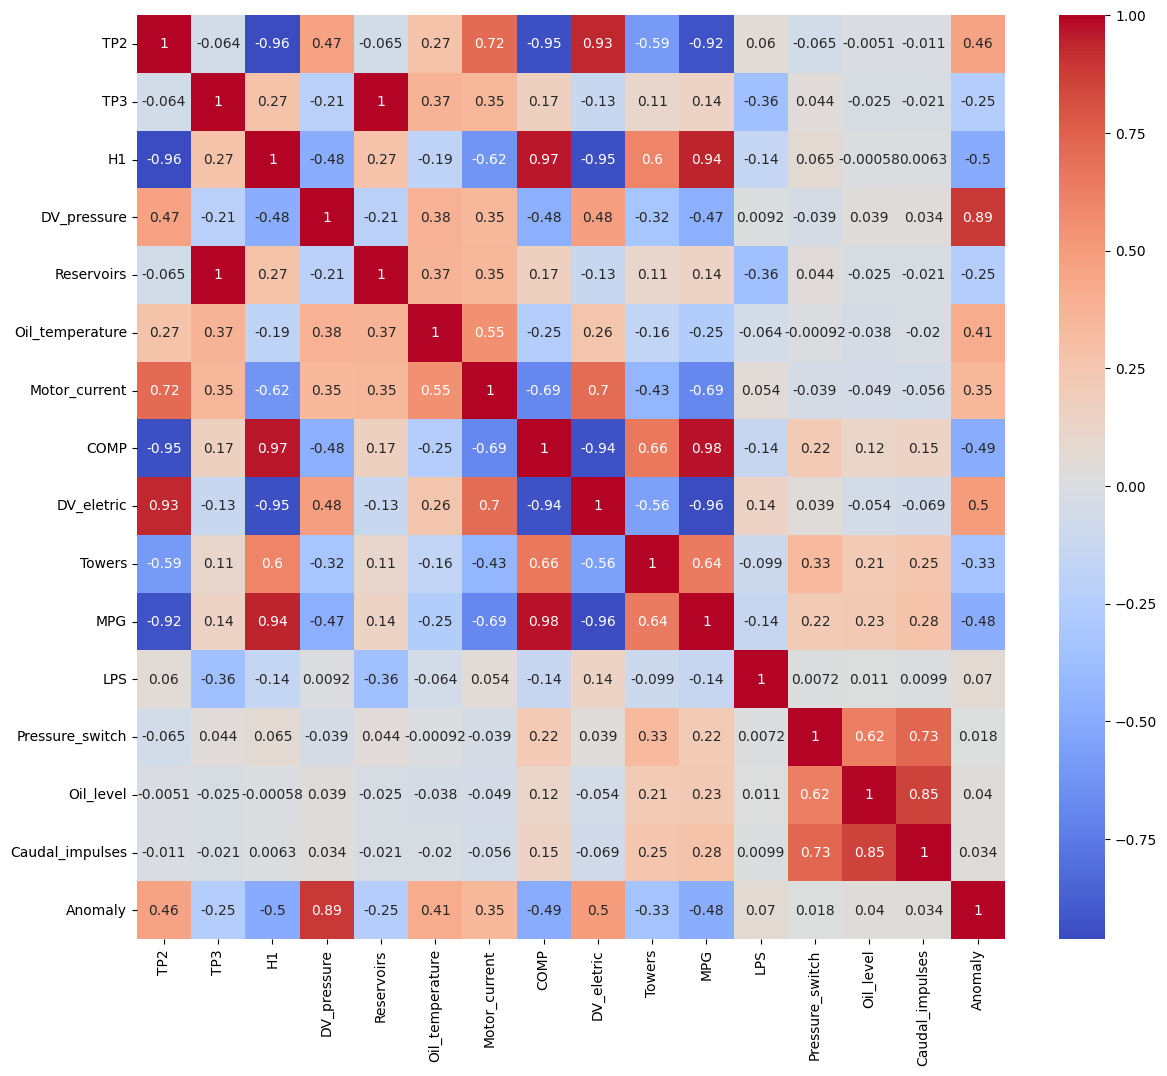

In [9]:
import seaborn as sns

corr_df = df.corr(method='pearson')
#mask_tr = np.triu(corr_df)

plt.figure(figsize=(14, 12))
#sns.heatmap(corr_df, annot=True, mask=mask_tr, cmap='coolwarm')
sns.heatmap(corr_df, annot=True,  cmap='coolwarm')

plt.show()

Si possono fare interessanti osservazioni l'anomalia, che ha una discreta correlazione positiva con gli attributi TP2, DV_pressure, Oil_temperature, DV_eletric, mentre si riscontra una correlazione negativa con COMP e MPG.


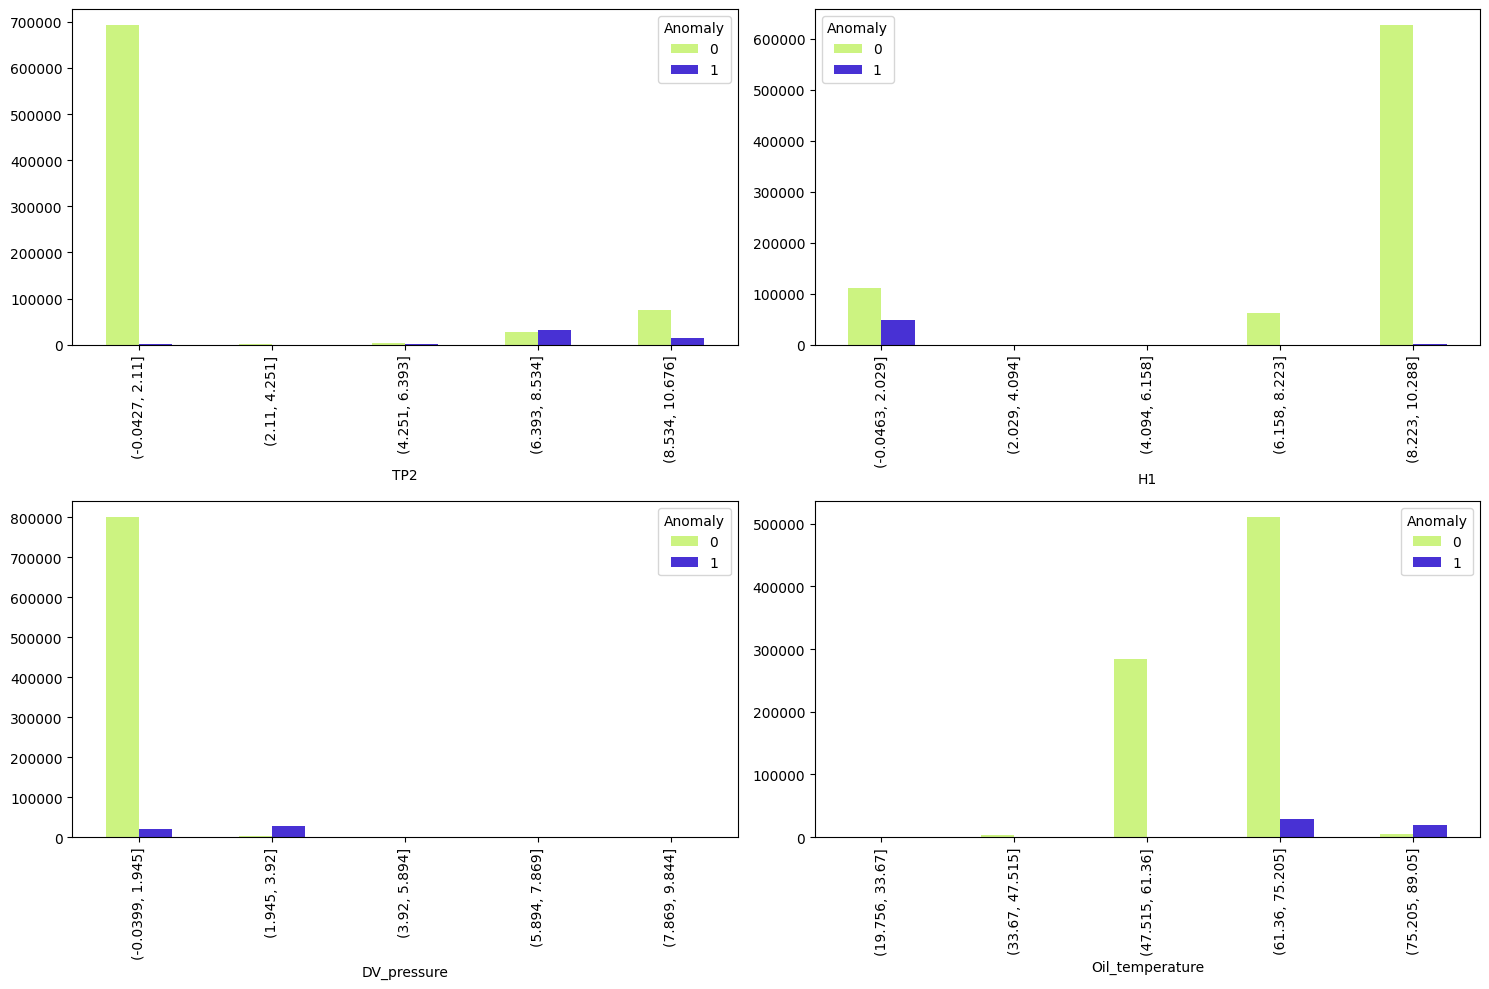

In [10]:
high_corr_analog = ["TP2", "H1", "DV_pressure", "Oil_temperature"]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, col in enumerate(high_corr_analog):
    bars = df.groupby(  [ pd.cut(df[col], bins=5), "Anomaly" ]  ).size().unstack("Anomaly")
    bars.plot(kind="bar", color=["#CCF381","#4831D4"], ax=axs[i//2, i%2])

plt.tight_layout()
plt.show()

Si può notare come i casi di anomalie per i valori assunti da queste variabili che presentano una discreta correlazione con la variabile Anomaly risultano essere distribuuiti in range circorscritti di valori. Di conseguenza queste variabili possono essere considerate sufficientemente valide per essere utilizzate per i nostri fini.

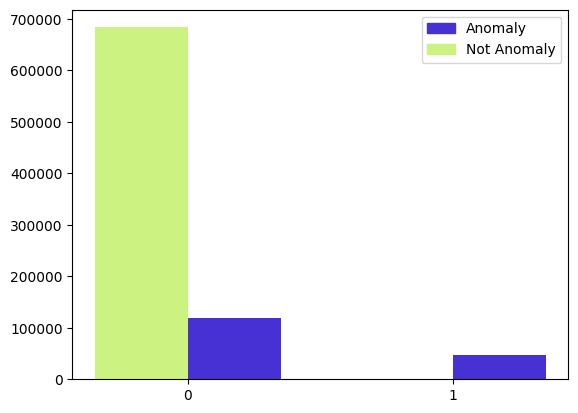

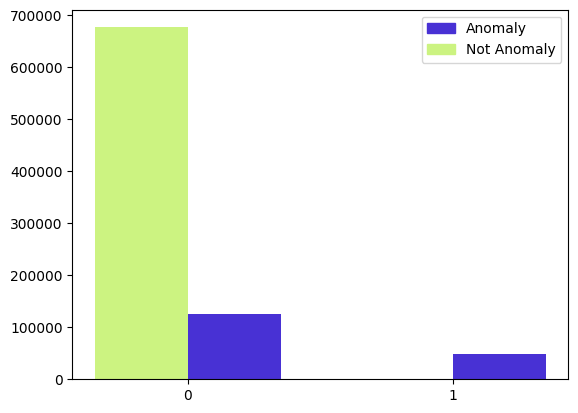

In [11]:
high_corr_digital = ["COMP", "MPG"]

width = 0.35

for col in high_corr_digital:
    fig, ax = plt.subplots()
    x_labels = ['0', '1']

    x = np.arange(len(x_labels))
    ax.bar(x + width/2, np.bincount(df["Anomaly"][df[col] == 0]), width, color=['#4831D4'])
    ax.bar(x - width/2, np.bincount(df["Anomaly"][df[col] == 1]), width, color=['#CCF381'])

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)

    colors = { 'Anomaly':'#4831D4', 'Not Anomaly':'#CCF381' }
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)
    plt.show()

Dai grafici è intuibile che per il valore 1 che è poco frequente per COMP e MPG, in proporzione corrisponde un alto tasso di anomalie. </br>
Per definizione i valori digitali COMP e MPG sono strettamente legati al valore analogico di H1 con cui infatti hanno entrambe una correlazione vicina ad 1.

### Variabili analogiche e digitali
Le varibili analogiche e digitali rappresentano in molti casi informazioni ridondanti, per questo abbiamo deciso di concentrare l'attenzione su quelle analogiche, che ci offrono maggior variazioni nei valori.
</br>
Analizziamo quindi come risultano distribuite le istanze con e senza anomalia rispetto a tutte le coppie di varibili analogiche.

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:97: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


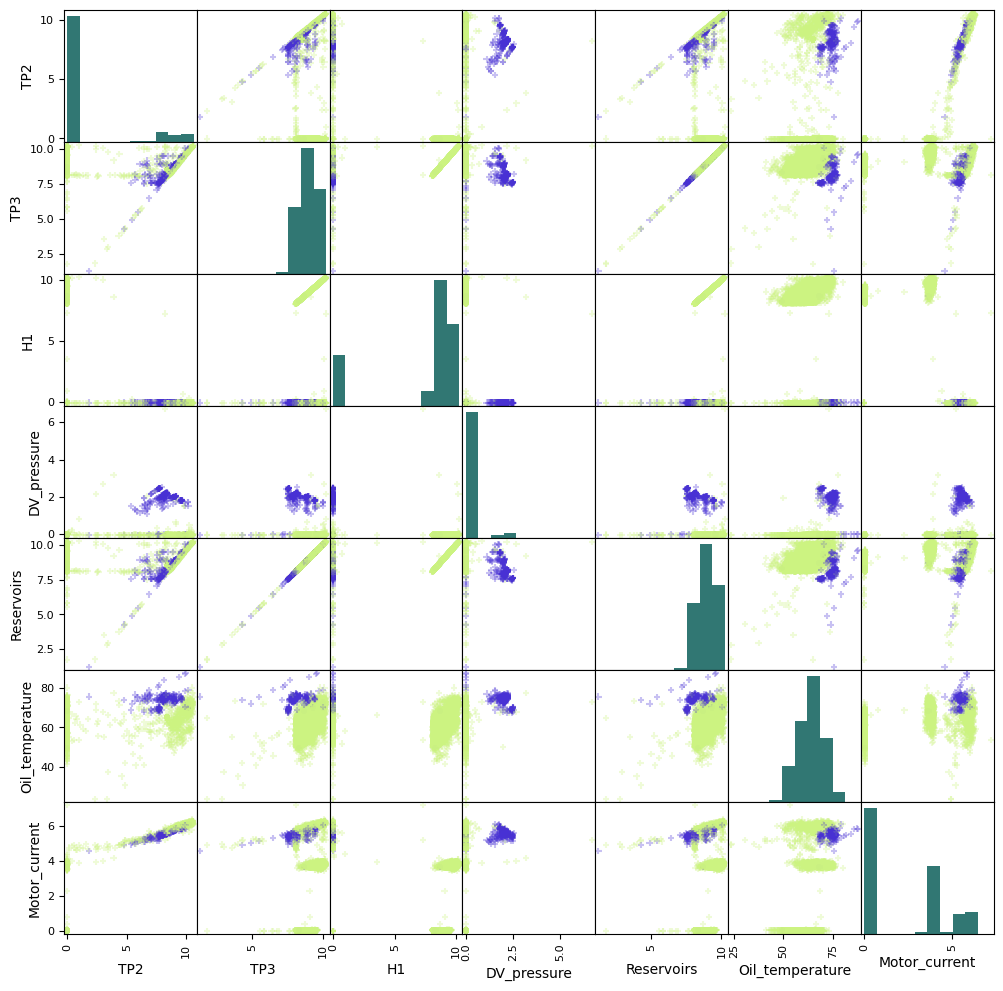

In [12]:
digital = ["COMP", "DV_eletric", "Towers", "MPG", "LPS", "Pressure_switch", "Oil_level", "Caudal_impulses"]

sample = df.sample(5000)
pd.plotting.scatter_matrix(sample.drop([*digital, "Anomaly"], axis=1),
                               c=sample["Anomaly"].map({0:'#CCF381', 1:'#4831D4'}),
                               alpha=0.3,
                               figsize=(12,12),
                               marker="+",
                               s=20,
                               hist_kwds={"bins": 10, "color": "#317773"});


Si può notare che nei grafici in cui è coinvolto DV_pressure la separazione tra le istanze con anomalie risultano chiaramente distaccate dalle altre in modo netto, viene confermata quindi l'osservazione fatta in precedenza sulla correlazione delle variabili con Anomaly per cui DV_pressure risultava la più alta.

## Preparazione Dati
(Linee guida: Preparare i dati per l’addestramento e la validazione dei modelli di predizione: isolare la variabile “target”
da predire e le variabili predittive, suddividere i dati in training e test set, eseguire eventuali operazioni di
preprocessing come ad es. one-hot encoding di variabili categoriche e oversampling o undersampling in
caso di classi sbilanciate.)

### Scelta features

In [147]:
analog_features_lag1 = {
    "TP2":              df["TP2"],
    #"TP3":              df["TP3"],
    "H1":               df["H1"],
    "DV_pressure":      df["DV_pressure"],
    #"Reservoirs":       df["Reservoirs"],
    "Oil_temperature":  df["Oil_temperature"],
    #"Motor_current":    df["Motor_current"],

    "TP2_lag1":                  df["TP2"].shift(1),
    #"TP3_lag1":                  df["TP3"].shift(1),
    "H1_lag1":                   df["H1"].shift(1),
    "DV_pressure_lag1":          df["DV_pressure"].shift(1),
    #"Reservoirs_lag1":           df["Reservoirs"].shift(1),
    "Oil_temperature_lag1":      df["Oil_temperature"].shift(1),
    #"Motor_current_lag1":        df["Motor_current"].shift(1),
}


analog_features_lag12 = {
    "TP2_lag1":                  df["TP2"].shift(1),
    #"TP3_lag1":                  df["TP3"].shift(1),
    "H1_lag1":                   df["H1"].shift(1),
    "DV_pressure_lag1":          df["DV_pressure"].shift(1),
    #"Reservoirs_lag1":           df["Reservoirs"].shift(1),
    "Oil_temperature_lag1":      df["Oil_temperature"].shift(1),
    #"Motor_current_lag1":        df["Motor_current"].shift(1),

    "TP2_lag2":                  df["TP2"].shift(2),
    #"TP3_lag2":                  df["TP3"].shift(2),
    "H1_lag2":                   df["H1"].shift(2),
    "DV_pressure_lag2":          df["DV_pressure"].shift(2),
    #"Reservoirs_lag2":           df["Reservoirs"].shift(2),
    "Oil_temperature_lag2":      df["Oil_temperature"].shift(2),
    #"Motor_current_lag2":        df["Motor_current"].shift(2),
}

X1 = pd.DataFrame(analog_features_lag1)[1:]
X2 = pd.DataFrame(analog_features_lag12)[2:]

y1 = df["Anomaly"].astype(np.uint8)[1:]
y2 = df["Anomaly"].astype(np.uint8)[2:]

In [149]:
from sklearn.model_selection import train_test_split

def split_train_val(X, y):
    period = X.index.month == 5
    period &= X.index.day >= 28
    period &= X.index.day <= 31
    #period &= X.index.month <=6
    X_train, X_val, y_train, y_val = train_test_split(
        X.loc[period],
        y.loc[period],
        test_size=1/3, random_state=42
    )

    X_train.index.isin(X_val.index).sum()

    y_val.value_counts(normalize=True)
    return X_train, X_val, y_train, y_val

X1_train, X1_val, y1_train, y1_val = split_train_val(X1, y1)
X2_train, X2_val, y2_train, y2_val = split_train_val(X2, y2)

## Addestramento, Validazione e Ricerca Iperparametri
(Addestramento e Validazione)
(Linee guida: Addestrare e validare due o più modelli di predizione, calcolandone le misure di performance viste nel
corso (es. MSE, errore relativo e coefficiente R² per modelli di regressione) e analizzando il modello
addestrato (es. coefficienti in una regressione lineare o nodi dei primi livelli di un albero decisionale) per
individuare le variabili più o meno rilevanti nella predizione.)

(Ricerca Iperparametri)
(Linee guida: Scegliere uno o più modelli di base (es. regressione ridge) ed eseguire una ricerca degli iperparametri
esaustiva (grid search) o a campione (randomized search) che massimizzi le performance del modello.)

### Cross-validation

In [150]:
from sklearn.model_selection import KFold, StratifiedKFold
kf = KFold(3, shuffle=True, random_state=42)
skf = StratifiedKFold(3, shuffle=True, random_state=42)

In [54]:
# KFold
for train, val in kf.split(X_train, y_train):
    print(y_train.iloc[val].value_counts())

0    44065
1     3224
Name: Anomaly, dtype: int64
0    43950
1     3339
Name: Anomaly, dtype: int64
0    44178
1     3110
Name: Anomaly, dtype: int64


In [55]:
# StratifiedKFold
for train, val in skf.split(X_train, y_train):
    print(y_train.iloc[val].value_counts())

0    44065
1     3224
Name: Anomaly, dtype: int64
0    44064
1     3225
Name: Anomaly, dtype: int64
0    44064
1     3224
Name: Anomaly, dtype: int64


### Modello xxx

- Perceptron
- Logistic Regression
- SVM
- Random Forest (alternativa Decision Tree)
- XGBClassifier

- Keras

In [151]:
from sklearn.model_selection import GridSearchCV

def gs_describe(gs, score):
    pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

    print("Cross validation best score: {}".format(gs.best_score_))
    print("Score: {}".format(score))
    print("Best parameters: {}".format(gs.best_params_))
    print("Best estimators: {}".format(gs.best_estimator_))

def grid_search_Xvalidation(model, grid, kf, X_train, X_val, y_train, y_val):
    gs = GridSearchCV(model, grid, cv=kf)

    gs.fit(X_train, y_train)
    score = gs.score(X_val, y_val)

    return gs, score

models = {}

In [152]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron

model = Pipeline([
    ("scaler", StandardScaler()),
    ("perceptron", Perceptron())
])

grid = {
    "scaler": [None, StandardScaler()],
    "perceptron__penalty": ["l2", "l1", "elasticnet"],
    "perceptron__alpha": np.logspace(-3, 3, 7),
    "perceptron__fit_intercept": [False, True]
}

In [153]:
%%time

gs1, score = grid_search_Xvalidation(model, grid, skf, X1_train, X1_val, y1_train, y1_val)
gs_describe(gs1, score)
pd.Series(gs1.best_estimator_.named_steps["perceptron"].coef_[0], index=X1_train.columns)

Cross validation best score: 0.9942946569175439
Score: 0.9962281942479962
Best parameters: {'perceptron__alpha': 0.001, 'perceptron__fit_intercept': False, 'perceptron__penalty': 'l1', 'scaler': None}
Best estimators: Pipeline(steps=[('scaler', None),
                ('perceptron',
                 Perceptron(alpha=0.001, fit_intercept=False, penalty='l1'))])
CPU times: user 9.46 s, sys: 6.62 s, total: 16.1 s
Wall time: 10.8 s


TP2                    -1056.978
H1                      -849.566
DV_pressure             1918.338
Oil_temperature         -140.805
TP2_lag1                -337.118
H1_lag1                 -989.076
DV_pressure_lag1        1796.032
Oil_temperature_lag1     208.655
dtype: float64

Dai coefficienti attribuiti alle variabili del modello si nota che le variabili con il lag hanno una forte influenza, in certi casi anche maggiore della rispettiva senza lag. Indaghiamo quindi anche una versione con features aventi lag 1 e 2.

In [154]:
%%time

gs2, score = grid_search_Xvalidation(model, grid, skf, X2_train, X2_val, y2_train, y2_val)
gs_describe(gs2, score)

models["Perceptron"] = { "model": gs2.best_estimator_, "score": score }
pd.Series(gs2.best_estimator_.named_steps["perceptron"].coef_[0], index=X2_train.columns)


Cross validation best score: 0.9954261986431451
Score: 0.9779349363507779
Best parameters: {'perceptron__alpha': 0.001, 'perceptron__fit_intercept': True, 'perceptron__penalty': 'l2', 'scaler': StandardScaler()}
Best estimators: Pipeline(steps=[('scaler', StandardScaler()),
                ('perceptron', Perceptron(alpha=0.001, penalty='l2'))])
CPU times: user 9.49 s, sys: 6.52 s, total: 16 s
Wall time: 10.4 s


TP2_lag1                0.025518
H1_lag1                -3.752721
DV_pressure_lag1        9.231408
Oil_temperature_lag1    6.629042
TP2_lag2               -1.631939
H1_lag2                -1.006752
DV_pressure_lag2       -1.384373
Oil_temperature_lag2    7.247075
dtype: float64

#TODO guardare significato valori coefficienti perceptron

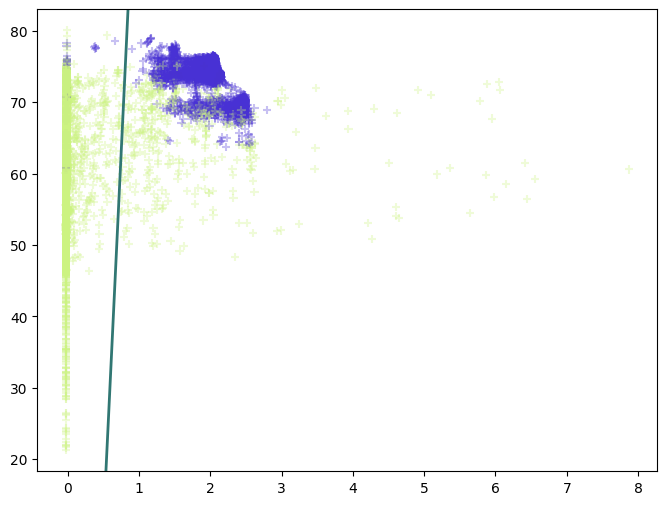

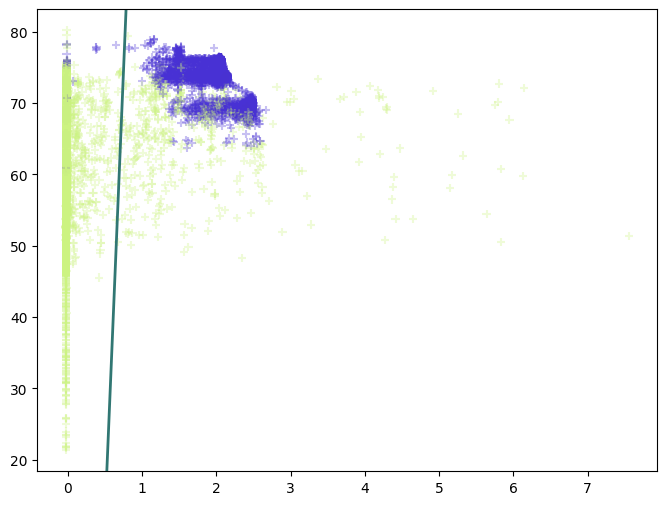

In [113]:
diagnosis_color_map = {0:'#CCF381', 1:'#4831D4'}

def separator_2d(model, x1):
    # ricaviamo w e b dal modello
    w = model.coef_[0]
    b = model.intercept_[0]
    # riportiamo in NumPy la formula sopra
    return -x1 * w[0] / w[1] - b / w[1]

def plot_separator_on_data(X, y, model=None):
    X = np.array(X)
    colors = pd.Series(y).map(diagnosis_color_map)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.3, marker="+", s=35)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        sep_x = np.linspace(*xlim, 2)
        sep_y = separator_2d(model, sep_x)
        plt.plot(sep_x, sep_y, c="#317773", linewidth=2)
        plt.xlim(xlim); plt.ylim(ylim)

model1 = Perceptron()
model2 = Perceptron()

model1.fit(X1_train.loc[:, ["DV_pressure","Oil_temperature_lag1"]], y1_train)
model2.fit(X2_train.loc[:, ["DV_pressure_lag1","Oil_temperature_lag2"]], y2_train)

plot_separator_on_data(X1_val.loc[:, ["DV_pressure","Oil_temperature_lag1"]], y1_val, model1)
plot_separator_on_data(X2_val.loc[:, ["DV_pressure_lag1","Oil_temperature_lag2"]], y2_val, model2)

In [155]:
X_train, X_val, y_train, y_val = X2_train, X2_val, y2_train, y2_val
# todo commentare e dire perchè

In [156]:
%%time

from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(solver="liblinear"))
])

grid = {
    "scaler": [None, StandardScaler()],
    "logreg__penalty": ["l2", "l1"],
    #"logreg__C": np.logspace(-3, 3, 7),
    "logreg__C": [1, 0.8, 0.3]
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score)

models["Logistic Regression"] = { "model": gs.best_estimator_, "score": score }

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Cross validation best score: 0.9988211773100192
Score: 0.9991513437057992
Best parameters: {'logreg__C': 1, 'logreg__penalty': 'l1', 'scaler': StandardScaler()}
Best estimators: Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=1, penalty='l1', solver='liblinear'))])
CPU times: user 36.9 s, sys: 2.05 s, total: 39 s
Wall time: 46 s


In [157]:
%%time

from sklearn.svm import SVC

model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

grid = {
    'svc__C': np.logspace(3, 5, 3),
    'svc__gamma': ['scale'],
    'svc__kernel': ['rbf']
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score)

models["SVC"] = { "model": gs.best_estimator_, "score": score }

Cross validation best score: 0.9990098142849874
Score: 0.9995285242809995
Best parameters: {'svc__C': 100000.0, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best estimators: Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=100000.0))])
CPU times: user 2.26 s, sys: 4.81 ms, total: 2.27 s
Wall time: 2.27 s


In [158]:
%%time

from sklearn.ensemble import RandomForestClassifier
import math

model = Pipeline([
    ("scaler", StandardScaler()),
    ("randomforest", RandomForestClassifier(n_jobs=-1, random_state=42))
])

num_features = X_train.columns.size

grid = {
    "scaler": [None, StandardScaler()],
    'randomforest__n_estimators': range(5, 10),
    'randomforest__min_samples_split': range(2, 5),
    'randomforest__max_depth': [None] + [i for i in range(1, 3)],
    'randomforest__max_features': [int(math.sqrt(num_features)), num_features - 1]
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score)

models["Random Forest"] = { "model": gs.best_estimator_, "score": score }

Cross validation best score: 0.9992927130556355
Score: 0.9994342291371995
Best parameters: {'randomforest__max_depth': None, 'randomforest__max_features': 7, 'randomforest__min_samples_split': 4, 'randomforest__n_estimators': 8, 'scaler': None}
Best estimators: Pipeline(steps=[('scaler', None),
                ('randomforest',
                 RandomForestClassifier(max_features=7, min_samples_split=4,
                                        n_estimators=8, n_jobs=-1,
                                        random_state=42))])
CPU times: user 15.2 s, sys: 1.2 s, total: 16.4 s
Wall time: 42.3 s


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=1)
model.fit(X_train, y_train);
model.score(X_val,y_val)

In [202]:
%%time

import xgboost
from xgboost import XGBClassifier

model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(objective="reg:squarederror"))
])

grid = {
    'xgb__eta': [0.001, 0.002, 0.1],
    'xgb__max_depth': [6, 9, 13],
    'xgb__n_estimators': [150, 300],
    'xgb__alpha': [0.0001, 0.001]
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score)

models["XGBoost"] = { "model": gs.best_estimator_, "score": score }

Cross validation best score: 0.9991041094287874
Score: 0.9990570485619991
Best parameters: {'xgb__alpha': 0.0001, 'xgb__eta': 0.001, 'xgb__max_depth': 9, 'xgb__n_estimators': 150}
Best estimators: Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(alpha=0.0001, base_score=None, booster=None,
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.001,
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_c

In [203]:
for model in models:
    print("{:<20}:\t{:.6f}".format(model, models[model]["score"]))

Perceptron          :	0.977935
Logistic Regression :	0.999151
SVC                 :	0.999529
Random Forest       :	0.999434
XGBoost             :	0.999057


#AA

- Precision, recall, f1 score, matrice di confusione
- confronto modelli con intervallo di confidenza
- confronto modello dummy

In [217]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

for model in models:
    print(model.upper(), "\n")
    m = models[model]["model"]
    y_pred = m.predict(X_val)

    print("Precision score: ", precision_score(y_val, y_pred))
    print("Recall score: ", recall_score(y_val, y_pred))
    print("F1 Score: ", f1_score(y_val, y_pred, average="macro"))
    print("Report:\n", classification_report(y_val, y_pred, digits=6), "\n")
    print("Matrice di confusione:\n", confusion_matrix(y_val, y_pred))
    print("\n\n")

PERCEPTRON 

Precision score:  0.7654822335025381
Recall score:  0.9960369881109643
F1 Score:  0.9268259585573263
Report:
               precision    recall  f1-score   support

           0   0.999688  0.976543  0.987980      9848
           1   0.765482  0.996037  0.865672       757

    accuracy                       0.977935     10605
   macro avg   0.882585  0.986290  0.926826     10605
weighted avg   0.982970  0.977935  0.979250     10605
 

Matrice di confusione:
 [[9617  231]
 [   3  754]]



LOGISTIC REGRESSION 

Precision score:  0.9973404255319149
Recall score:  0.9907529722589168
F1 Score:  0.996789477842856
Report:
               precision    recall  f1-score   support

           0   0.999290  0.999797  0.999543      9848
           1   0.997340  0.990753  0.994036       757

    accuracy                       0.999151     10605
   macro avg   0.998315  0.995275  0.996789     10605
weighted avg   0.999150  0.999151  0.999150     10605
 

Matrice di confusione:
 [[9846    

In [218]:
# TODO fix
from scipy import stats

def model_difference(e1, e2, conf):
    z_half_alfa = stats.norm.ppf(conf)
    variance = (((1 - e1) * e1) / len(y_val)) + (((1 - e2) * e2) / len(y_val))
    d_minus = abs(e1 - e2) - z_half_alfa * (pow(variance, 0.5))
    d_plus = abs(e1 - e2) + z_half_alfa * (pow(variance, 0.5))
    print("Valore minimo: {}\nValore massimo: {}\n".format(d_minus, d_plus))

for model in models:
    err1 = 1 - ... # f1 score del modello
    err2 = 1 - ... # f1 score del modello

In [214]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier()
model.fit(X_train, y_train)
score = model.score(X_val, y_val)

predict = model.predict(X_val)
print(classification_report(y_val, predict, digits=5))

              precision    recall  f1-score   support

           0    0.92862   1.00000   0.96299      9848
           1    0.00000   0.00000   0.00000       757

    accuracy                        0.92862     10605
   macro avg    0.46431   0.50000   0.48149     10605
weighted avg    0.86233   0.92862   0.89425     10605



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
failure_start_1 = (X.index > datetime.datetime(2020, 4, 12, 11, 49, 0)) & (X.index <= datetime.datetime(2020, 4, 12, 11, 51, 0))
failure_start_2 = (X.index > datetime.datetime(2020, 5, 18, 4, 59, 0)) & (X.index <= datetime.datetime(2020, 5, 18, 5, 1, 0))
y[failure_start_2]

In [ ]:
print(X[failure_start_2].index)
model.predict(X[failure_start_2])